# 超分辨重建实验
什么是超分辨重建？简单的说就是一张或多张分辨率低退化的图像，通过一定的技术手段，生成高分辨率纹理清晰的图像,如图所示。在实际中，图像超分辨率重建技术是非常有用的，在监控领域，卫星图像遥感领域，医学图像领域有着广泛的应用。最简单的超分辨重建技术是基于插值的算法，比如最近邻插值，双线性插值等，也有基于传统机器学习的算法，比如稀疏表示法等。
<center > ![超分辨](./SR.PNG) </center>

近年来，基于深度学习的超分辨重建技术兴起，各种技术层出不穷，本实验主要介绍基于生成对抗网络的超分辨重建-SRGAN。

## SRGAN
SRGAN的核心思想是使用perceptual loss来替代pixel-wise的MSE loss，作者认为这更能接近人的主观感受，pixel-wise的MSE会使图像变得平滑，而是用预训练的VGG19模型来提取图像的纹理信息，构建基于feature maps的MSE loss，即perceputal loss。除此之外，SRGAN引入生成对抗网络，迫使网络生成接近于自然的高保真的图像，故perceptual loss由两部分组成，的定义如下：

$$ l^{SR} = l_{X}^{SR} + 10^{-3}l_{Gen}^{SR}$$

其中$l_{X}^{SR}$为content loss  $l_{Gen}^{SR}$为adversarial loss。

* content loss

  content loss可以使用基于pixel-wise的MSE loss, 但会导致平滑，丢失高频信息，所以使用预训练的VGG提取感知信息来替代pixel-wise
  MSE，其表达形式如下公式：
  
  $$ l_{VGG/i.j}^{SR} = \frac{1}{W_{i,j}H_{i,j}}\sum_{x=1}^{W_{i,j}}\sum_{y=1}^{H_{i,j}}(\phi_{i,j}(I^{HR})_{x,y} - \phi_{i,j}(G_{\theta}(I^{LR}))_{x,y})$$
  
* adversarial loss
  
  除了上面的content loss，还要增加生成对抗网络中的生成器所产生的损失，迫使生成器产生接近自然清晰的图像，其形式定义如下：
  
  $$ l_{Gen}^{SR} = \sum_{n=1}^{N}-\log D_{\theta}(G_{\theta}(I^{LR}))$$


## 人脸超分辨重建实验
人脸数据是使用dlib库从人脸识别数据集LFW中提取出来的，并统一到96x96大小，训练集约12000张

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR) # 屏蔽警告

In [2]:
# 封装一些用到的网络层
def lrelu(x, trainable=None):
    alpha = 0.2
    return tf.maximum(alpha*x, x)

def prelu(x, trainable=True):
    alpha = tf.get_variable(name='alpha',
                           shape=x.get_shape()[-1],
                           dtype=tf.float32,
                           initializer=tf.constant_initializer(0.),
                           trainable=trainable)
    return tf.maximum(0., x) + alpha*tf.minimum(0., x)

def conv_layer(x, filter_shape, stride, trainable=True):
    filter= tf.get_variable(name='weight',
                           shape=filter_shape,
                           dtype=tf.float32,
                           initializer=tf.glorot_uniform_initializer(),
                           trainable=trainable)
    
    return tf.nn.conv2d(input=x, filter=filter,
                        strides=[1, stride, stride, 1],
                        padding='SAME')

def deconv_layer(x, filter_shape, output_shape, stride, trainable=True):
    filter = tf.get_variable(name='weight',
                            shape=filter_shape,
                            dtype=tf.float32,
                            initializer=tf.glorot_uniform_initializer(),
                            trainable=trainable)
    return tf.nn.conv2d_transpose(value=x, filter=filter,
                                 output_shape=output_shape,
                                 strides=[1, stride,stride,1])
    
def max_pooling_layer(x, size, stride):
    return tf.nn.max_pool(value=x, ksize=[1, size, size,1],
                         strides=[1, stride, stride, 1],
                         padding='SAME')

def avg_pooling_layer(x, size, stride):
    return tf.nn.avg_pool(value=x, ksize=[1,size,size,1],
                         strides=[1, stride, stride, 1],
                         padding='SAME')

def full_connection_layer(x, out_dim, trainable=True):
    in_dim = x.get_shape().as_list()[-1]
    weight = tf.get_variable(name='weight',
                            shape=[in_dim,out_dim],
                            dtype=tf.float32,
                            initializer=tf.glorot_normal_initializer(),
                            trainable=trainable)
    bias = tf.get_variable(name='bias',
                          shape=[out_dim],
                          dtype=tf.float32,
                          initializer=tf.constant_initializer(0.),
                          trainable=trainable)
    
    return tf.add(tf.matmul(x,weight),bias)
  
def batch_normalize(x, is_training, decay=0.99, epsilon=0.001,trainable=True):
    def bn_train():
        batch_mean,batch_var = tf.nn.moments(x, axes=[0,1,2])
        train_mean = tf.assign(pop_mean, pop_mean*decay + batch_mean*(1-decay))
        train_var  = tf.assign(pop_var, pop_var*decay + batch_var*(1-decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x,pop_mean,pop_var,beta,scale,epsilon)
        
    
    def bn_inference():
        return tf.nn.batch_normalization(x, pop_mean,pop_var,beta, scale,epsilon)
    
    dim = x.get_shape().as_list()[-1]
    beta = tf.get_variable(name='beta',
                          shape=[dim],
                          dtype=tf.float32,
                          initializer=tf.constant_initializer(0.),
                          trainable=trainable)
    scale = tf.get_variable(name='scale',
                           shape=[dim],
                           dtype=tf.float32,
                           initializer=tf.constant_initializer(1.0),
                           trainable=trainable)
    pop_mean = tf.get_variable(name='pop_mean',
                              shape=[dim],
                              dtype=tf.float32,
                              initializer=tf.constant_initializer(0.),
                              trainable=False)
    pop_var = tf.get_variable(name='pop_var',
                             shape=[dim],
                             dtype=tf.float32,
                             initializer=tf.constant_initializer(1.0),
                             trainable=False)
    return tf.cond(is_training,bn_train,bn_inference)

def flatten_layer(x):
    input_shape=x.get_shape().as_list()
    dim = input_shape[1]*input_shape[2]*input_shape[3]
    transposed = tf.transpose(x,(0,3,1,2))
    return tf.reshape(transposed,[-1,dim])

def pixel_shuffle_layer(x,r,n_split):
    def PS(x,r):
        bs,a,b,c = x.get_shape().as_list()
        x = tf.reshape(x, (bs,a,b,r,r))
        x = tf.transpose(x, (0,1,2,4,3))
        x = tf.split(x, a, 1)
        x = tf.concat([tf.squeeze(x_) for x_ in x],2)
        x = tf.split(x,b,1)
        x = tf.concat([tf.squeeze(x_) for x_ in x],2)
        return tf.reshape(x,(bs, a*r,b*r,1))
    xc = tf.split(x, n_split, 3)
    return tf.concat([PS(x_, r) for x_ in xc], 3)

下面定义VGG19的网络结构，用于提取content loss

In [3]:
class VGG19:
    def __init__(self, x, t, is_training):
        if x is None:
            return 
        self.out, self.phi = self.build_model(x, is_training)
        self.loss = self.inference_loss(self.out, t)
    
    def build_model(self, x, is_training, reuse=False):
        with tf.variable_scope('vgg19',reuse=reuse):
            phi = []
            # stage 1
            with tf.variable_scope('conv1a'):
                x = conv_layer(x, [3,3,3,64],1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv1b'):
                x = conv_layer(x, [3,3,64,64],1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            phi.append(x)
            # stage 2
            x = max_pooling_layer(x, 2, 2)
            with tf.variable_scope('conv2a'):
                x = conv_layer(x, [3,3,64,128],1) 
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv2b'):
                x = conv_layer(x, [3,3,128,128], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            phi.append(x)
            # stage 3
            x = max_pooling_layer(x, 2, 2)
            with tf.variable_scope('conv3a'):
                x = conv_layer(x, [3,3,128,256], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv3b'):
                x = conv_layer(x,[3,3,256,256], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv3c'):
                x = conv_layer(x,[3,3,256,256], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv3d'):
                x = conv_layer(x,[3,3,256,256], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            phi.append(x)
            # stage 4
            x = max_pooling_layer(x, 2,2)
            with tf.variable_scope('conv4a'):
                x = conv_layer(x, [3,3,256,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv4b'):
                x = conv_layer(x, [3,3,512,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv4c'):
                x = conv_layer(x, [3,3,512,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv4d'):
                x = conv_layer(x, [3,3,512,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            phi.append(x)
            # stage 5
            x = max_pooling_layer(x,2,2)
            with tf.variable_scope('conv5a'):
                x = conv_layer(x, [3,3,512,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv5b'):
                x = conv_layer(x, [3,3,512,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv5c'):
                x = conv_layer(x, [3,3,512,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            with tf.variable_scope('conv5d'):
                x = conv_layer(x,[3,3,512,512], 1)
                x = batch_normalize(x, is_training)
                x = lrelu(x)
            phi.append(x)
            
            x = max_pooling_layer(x, 2,2)
            x = flatten_layer(x)
            with tf.variable_scope('fc1'):
                x = full_connection_layer(x, 4096)
                x = lrelu(x)
            with tf.variable_scope('fc2'):
                x = full_connection_layer(x, 4096)
                x = lrelu(x)
            with tf.variable_scope('softmax'):
                x = full_connection_layer(x, 100)
                
            return x, phi
        
        def inference_loss(self, out, t):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(t,100),
                                                                   logits=out)
            return tf.reduce_mean(cross_entropy)

定义SRGAN的生成器与判别器

In [4]:
class SRGAN:
    def __init__(self, x, is_training, batch_size):
        self.batch_size = batch_size
        self.vgg = VGG19(None, None, None)
        self.downscaled = self.downscale(x)
        self.imitation = self.generator(self.downscaled, is_training,False)
        self.real_output = self.discriminator(x, is_training, False)
        self.fake_output = self.discriminator(self.imitation, is_training, True)
        self.g_loss,self.d_loss = self.inference_losses(x,
                                                       self.imitation, self.real_output,self.fake_output)
        
    # 定义生成器 
    def generator(self, x, is_training, reuse):
        with tf.variable_scope('generator', reuse=reuse):
            with tf.variable_scope('deconv1'):
                x = deconv_layer(x, [3,3,64,3], [self.batch_size, 24,24,64],1)
                x = tf.nn.relu(x)
                shortcut = x
                for i in range(5):
                    mid = x
                    with tf.variable_scope('block{}a'.format(i+1)):
                        x = deconv_layer(x, [3,3,64,64],[self.batch_size,24,24,64],1)
                        x = batch_normalize(x, is_training)
                        x = tf.nn.relu(x)
                    with tf.variable_scope('block{}b'.format(i+1)):
                        x = deconv_layer(x, [3,3,64,64],[self.batch_size,24,24,64],1)
                        x = batch_normalize(x, is_training)
                    x = tf.add(x,mid)
                with tf.variable_scope('deconv2'):
                    x = deconv_layer(x,[3,3,64,64], [self.batch_size, 24,24,64],1)
                    x = batch_normalize(x, is_training)
                    x = tf.add(x, shortcut)

                with tf.variable_scope('deconv3'):
                    x = deconv_layer(x,[3,3,256,64],[self.batch_size,24,24,256],1)
                    x = pixel_shuffle_layer(x,2,64)
                    x = tf.nn.relu(x)

                with tf.variable_scope('deconv4'):
                    x = deconv_layer(x, [3,3,64,64], [self.batch_size,48,48,64],1)
                    x = pixel_shuffle_layer(x,2,16)
                    x =tf.nn.relu(x)
                with tf.variable_scope('deconv5'):
                    x = deconv_layer(x,[3,3,3,16],[self.batch_size, 96,96,3],1)
                    x = tf.nn.tanh(x) # 此处一定使用tanh函数，避免产生颜色噪声点

                self.g_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='generator')
                return  x
    # 定义判别器        
    def discriminator(self, x, is_training, reuse):
        with tf.variable_scope('discriminator', reuse=reuse):
            with tf.variable_scope('conv1'):
                x = conv_layer(x,[3,3,3,64],1)
                x = lrelu(x)

            with tf.variable_scope('conv2'):
                x = conv_layer(x,[3,3,64,64],2)
                x = lrelu(x)
                x = batch_normalize(x, is_training)
            with tf.variable_scope('conv3'):
                x = conv_layer(x,[3,3,64,128],1)
                x = lrelu(x)
                x = batch_normalize(x, is_training)
            with tf.variable_scope('conv4'):
                x = conv_layer(x, [3,3,128,128],2)
                x = lrelu(x)
                x = batch_normalize(x, is_training)
            with tf.variable_scope('conv5'):
                x = conv_layer(x,[3,3,128,256],1)
                x = lrelu(x)
                x = batch_normalize(x, is_training)

            with tf.variable_scope('conv6'):
                x = conv_layer(x,[3,3,256,256], 2)
                x = lrelu(x)
                x = batch_normalize(x, is_training)
            with tf.variable_scope('conv7'):
                x = conv_layer(x,[3,3,256,512],1)
                x = lrelu(x)
                x = batch_normalize(x, is_training)
            with tf.variable_scope('conv8'):
                x = conv_layer(x,[3,3,512,512],1)
                x = lrelu(x)
                x = batch_normalize(x, is_training)
            x = flatten_layer(x)
            with tf.variable_scope('fc'):
                x = full_connection_layer(x,1024)
                x = lrelu(x)
            with tf.variable_scope('softmax'):
                x = full_connection_layer(x,1)

        self.d_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,  scope='discriminator')
        return x
    # 下采样生成低分辨图 
    def downscale(self, x):
        k = 4
        arr = np.zeros([k,k,3,3])
        arr[:,:,0,0] = 1.0/k**2
        arr[:,:,1,1] = 1.0/k**2
        arr[:,:,2,2] = 1.0/k**2
        weight = tf.constant(arr,dtype=tf.float32)
        downscaled = tf.nn.conv2d(x,weight,strides=[1,k,k,1],padding='SAME')
        return downscaled
    # 定义 损失函数   
    def inference_losses(self, x, imitation, true_output, fake_output):
        # 定义content loss
        def inference_content_loss(x, imitation):
            _,x_phi = self.vgg.build_model(x,tf.constant(False),False)
            _,imitation_phi = self.vgg.build_model(imitation, tf.constant(False),True)

            content_loss = None

            for i in range(len(x_phi)):
                l2_loss = tf.nn.l2_loss(x_phi[i] - imitation_phi[i])
                if content_loss is None:
                    content_loss = l2_loss
                else:
                    content_loss = content_loss + l2_loss
            return tf.reduce_mean(content_loss)
        # 定义对抗L2损失函数  
        def inference_adversarial_loss(real_output, fake_output):
            alpha = 1e-5
            g_loss = tf.reduce_mean(tf.nn.l2_loss(fake_output - tf.ones_like(fake_output)))
            d_loss_real = tf.reduce_mean(tf.nn.l2_loss(real_output - tf.ones_like(true_output)))
            d_loss_fake = tf.reduce_mean(tf.nn.l2_loss(fake_output - tf.zeros_like(fake_output)))
            d_loss = d_loss_real + d_loss_fake
            #return (g_loss*alpha, d_loss*alpha)
            return (g_loss*alpha, d_loss)
        # 定义对抗损失函数    
        def inference_adversarial_loss_with_sigmoid(real_output, fake_output):
            alpha = 1e-3
            g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_output),
                                                            logits=fake_output))
            d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output),
                                                                 logits=real_output))
            d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_output),
                                                                 logits=fake_output))
            d_loss = d_loss_real + d_loss_fake
            #return (g_loss*alpha, d_loss*alpha)
            return (g_loss*alpha, d_loss)

        content_loss = inference_content_loss(x, imitation)
        generator_loss, discriminator_loss = inference_adversarial_loss(true_output, fake_output)

        g_loss = content_loss + generator_loss
        d_loss = discriminator_loss
        return (g_loss, d_loss)

In [5]:
# 数据规整到[-1,1]
def normalize(images):
    return np.array([image/127.5-1 for image in images])

def save_img(imgs, label, epoch):
    for i in range(batch_size):
        fig = plt.figure()
        for j, img in enumerate(imgs):
            im = np.uint8((img[i]+1)*127.5)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            if label[j] == 'bicubic':
                im = cv2.resize(im, (96,96),interpolation=cv2.INTER_CUBIC)
            fig.add_subplot(1, len(imgs), j+1)
            plt.imshow(im)
            plt.tick_params(labelbottom='off')
            plt.tick_params(labelleft='off')
            plt.gca().get_xaxis().set_ticks_position('none')
            plt.gca().get_yaxis().set_ticks_position('none')
            plt.xlabel(label[j])
        plt.show()
        #plt.close()

下面设置训练参数，开始训练

In [6]:
learning_rate = 1e-3
batch_size = 16
epoch_num = 100

vgg_model = './vgg19_model/latest'

x = tf.placeholder(tf.float32, [None, 96,96,3])
is_training = tf.placeholder(tf.bool,[])

model = SRGAN(x,is_training,batch_size)
sess = tf.Session()
with tf.variable_scope('srgan'):
    global_step = tf.Variable(0,name='global_step',trainable=False)

opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
g_train_op = opt.minimize(model.g_loss, global_step=global_step, var_list=model.g_variables)
d_train_op = opt.minimize(model.d_loss, global_step=global_step, var_list=model.d_variables)

init = tf.global_variables_initializer()
sess.run(init)

var = tf.global_variables()
vgg_var = [var_ for var_ in var if 'vgg19' in var_.name]

saver = tf.train.Saver(vgg_var)
saver.restore(sess,vgg_model)

x_train = np.load('./LFW/npy/x_train.npy')
x_test = np.load('./LFW/npy/x_test.npy')

n_iter = int(len(x_train)/batch_size)
print('Training starting!')
while True:
    epoch = int(sess.run(global_step)/n_iter/2) + 1
    np.random.shuffle(x_train)
    for i in tqdm(range(n_iter)):
        x_batch = normalize(x_train[i*batch_size:(i+1)*batch_size])
        _,_,g_ls,d_ls=sess.run([g_train_op,d_train_op,model.g_loss,model.d_loss],
                               feed_dict={x:x_batch,is_training:True})
    print("epoch:{}, g_loss: {}, d_loss:{}".format(epoch, g_ls, d_ls))
    if epoch >= epoch_num:
        print('Training finished! ')
        break

Training starting!


100%|██████████| 731/731 [03:16<00:00,  5.15it/s]


epoch:1, g_loss: 21214.4375, d_loss:277308.75


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:2, g_loss: 11608.796875, d_loss:2723.86669921875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:3, g_loss: 6255.98095703125, d_loss:492.695556640625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:4, g_loss: 6061.1455078125, d_loss:311.14031982421875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:5, g_loss: 6289.80810546875, d_loss:119.558837890625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:6, g_loss: 7594.07958984375, d_loss:146.62347412109375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:7, g_loss: 6563.42333984375, d_loss:101.30868530273438


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:8, g_loss: 4495.845703125, d_loss:144.22854614257812


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:9, g_loss: 5546.80029296875, d_loss:610.5848388671875


100%|██████████| 731/731 [02:22<00:00,  5.11it/s]


epoch:10, g_loss: 4937.4052734375, d_loss:423.2657775878906


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:11, g_loss: 5794.77587890625, d_loss:3130.85791015625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:12, g_loss: 5797.54150390625, d_loss:344063.09375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:13, g_loss: 5266.1513671875, d_loss:22277.287109375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:14, g_loss: 4640.25048828125, d_loss:25443.6484375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:15, g_loss: 6327.93505859375, d_loss:6054.69580078125


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:16, g_loss: 4936.2216796875, d_loss:4528.2880859375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:17, g_loss: 4008.57275390625, d_loss:2097.101806640625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:18, g_loss: 10296.5068359375, d_loss:1989.42919921875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:19, g_loss: 4076.244384765625, d_loss:990.24169921875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:20, g_loss: 5462.75146484375, d_loss:979.6318359375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:21, g_loss: 4350.36962890625, d_loss:1878.970458984375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:22, g_loss: 4257.65625, d_loss:15481.9384765625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:23, g_loss: 4546.6640625, d_loss:1127.48486328125


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:24, g_loss: 4163.55126953125, d_loss:287.2994689941406


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:25, g_loss: 4608.7333984375, d_loss:281.57208251953125


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:26, g_loss: 4157.9609375, d_loss:833.7633056640625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:27, g_loss: 3847.3330078125, d_loss:483.0631103515625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:28, g_loss: 4296.10107421875, d_loss:2050.480224609375


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:29, g_loss: 3598.236083984375, d_loss:1936428.5


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:30, g_loss: 4882.95458984375, d_loss:157279.6875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:31, g_loss: 3702.625732421875, d_loss:18074.591796875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:32, g_loss: 3864.794189453125, d_loss:6164.173828125


100%|██████████| 731/731 [02:22<00:00,  5.12it/s]


epoch:33, g_loss: 3999.17236328125, d_loss:11219.662109375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:34, g_loss: 3556.549560546875, d_loss:2784.1494140625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:35, g_loss: 6881.9560546875, d_loss:93329744.0


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:36, g_loss: 3926.54833984375, d_loss:12960.509765625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:37, g_loss: 4154.5986328125, d_loss:27039.966796875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:38, g_loss: 3130.9736328125, d_loss:2161.001708984375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:39, g_loss: 3810.318115234375, d_loss:909.4937744140625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:40, g_loss: 3137.237060546875, d_loss:413.89532470703125


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:41, g_loss: 3817.451904296875, d_loss:1473.8375244140625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:42, g_loss: 2912.869873046875, d_loss:478.85345458984375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:43, g_loss: 3333.199951171875, d_loss:581.0179443359375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:44, g_loss: 3519.63330078125, d_loss:508.06695556640625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:45, g_loss: 3616.04833984375, d_loss:49.00802993774414


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:46, g_loss: 3384.087890625, d_loss:92.67265319824219


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:47, g_loss: 3150.709228515625, d_loss:36.7838134765625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:48, g_loss: 3046.4052734375, d_loss:15390.71484375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:49, g_loss: 2804.693603515625, d_loss:49.85597610473633


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:50, g_loss: 3893.52294921875, d_loss:45.1796760559082


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:51, g_loss: 3060.24560546875, d_loss:84.29695129394531


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:52, g_loss: 3057.046142578125, d_loss:89.04261016845703


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:53, g_loss: 3494.380615234375, d_loss:3958.74560546875


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:54, g_loss: 3000.673583984375, d_loss:269.74530029296875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:55, g_loss: 3038.460205078125, d_loss:405.05743408203125


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:56, g_loss: 2953.2021484375, d_loss:48.48833465576172


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:57, g_loss: 2556.1337890625, d_loss:124.6473159790039


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:58, g_loss: 3608.078857421875, d_loss:100.8577880859375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:59, g_loss: 3143.54345703125, d_loss:170.34646606445312


100%|██████████| 731/731 [02:22<00:00,  5.12it/s]


epoch:60, g_loss: 3247.4375, d_loss:178.40911865234375


100%|██████████| 731/731 [02:22<00:00,  5.12it/s]


epoch:61, g_loss: 3175.77490234375, d_loss:213.60179138183594


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:62, g_loss: 3429.8115234375, d_loss:5562.50390625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:63, g_loss: 2975.672119140625, d_loss:1198.674560546875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:64, g_loss: 2819.273681640625, d_loss:412.38470458984375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:65, g_loss: 3786.778564453125, d_loss:310.9494934082031


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:66, g_loss: 3527.67724609375, d_loss:274.88623046875


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:67, g_loss: 3551.441162109375, d_loss:177.1392364501953


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:68, g_loss: 2638.117431640625, d_loss:423.6843566894531


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:69, g_loss: 2838.812255859375, d_loss:6305.0908203125


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:70, g_loss: 3702.779541015625, d_loss:460.350830078125


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:71, g_loss: 3844.758056640625, d_loss:369.71649169921875


100%|██████████| 731/731 [02:22<00:00,  5.12it/s]


epoch:72, g_loss: 3509.9853515625, d_loss:101.24058532714844


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:73, g_loss: 3896.49755859375, d_loss:545.7998046875


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:74, g_loss: 3626.9619140625, d_loss:450.00140380859375


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:75, g_loss: 3745.689453125, d_loss:100.56017303466797


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:76, g_loss: 4170.21826171875, d_loss:451.219970703125


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:77, g_loss: 3257.041748046875, d_loss:48.619850158691406


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:78, g_loss: 3483.635498046875, d_loss:29.226638793945312


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:79, g_loss: 2952.99267578125, d_loss:13.140115737915039


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:80, g_loss: 2904.299560546875, d_loss:27.229602813720703


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:81, g_loss: 3568.1220703125, d_loss:1059.263427734375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:82, g_loss: 3230.10888671875, d_loss:53.03126525878906


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:83, g_loss: 3119.06689453125, d_loss:10.740724563598633


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:84, g_loss: 3969.992919921875, d_loss:32.482879638671875


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:85, g_loss: 3140.13037109375, d_loss:396132.625


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:86, g_loss: 2111.302978515625, d_loss:13898.552734375


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:87, g_loss: 2429.3994140625, d_loss:2064.28125


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]


epoch:88, g_loss: 3030.285400390625, d_loss:626.3982543945312


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:89, g_loss: 2909.796142578125, d_loss:1101.8509521484375


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:90, g_loss: 2535.23193359375, d_loss:8975.8984375


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:91, g_loss: 2893.548095703125, d_loss:758.2235107421875


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:92, g_loss: 3513.726318359375, d_loss:330.3364562988281


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:93, g_loss: 3304.7998046875, d_loss:5083.7529296875


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:94, g_loss: 2842.35205078125, d_loss:530.1705322265625


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:95, g_loss: 2759.2109375, d_loss:22851.9765625


100%|██████████| 731/731 [02:22<00:00,  5.12it/s]


epoch:96, g_loss: 2860.835205078125, d_loss:3508.673828125


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:97, g_loss: 2558.572998046875, d_loss:2164.39892578125


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:98, g_loss: 3817.8388671875, d_loss:1774.6705322265625


100%|██████████| 731/731 [02:22<00:00,  5.13it/s]


epoch:99, g_loss: 3019.57080078125, d_loss:1140.1875


100%|██████████| 731/731 [02:22<00:00,  5.14it/s]

epoch:100, g_loss: 3298.52978515625, d_loss:1982.0306396484375
Training finished! 


训练完毕后，从测试集中抽取一部分数据作为超分辨效果的展示。为了观察实验效果，分别采用下采样的结果(Input),双三次插值的结果(Bicubic),SRGAN的结果（Output）以及Ground Truth的进行对比，如下图所示：

/usr/local/SkyCompute/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


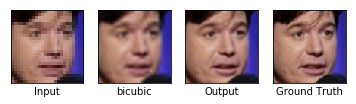

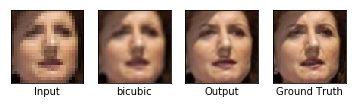

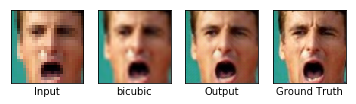

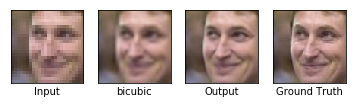

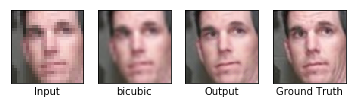

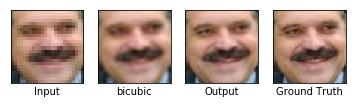

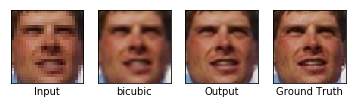

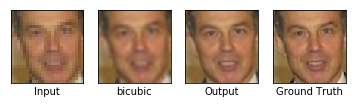

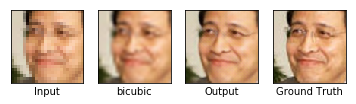

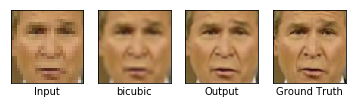

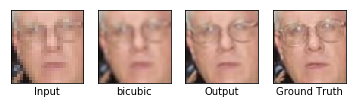

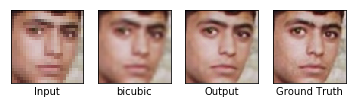

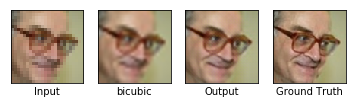

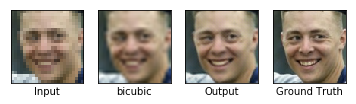

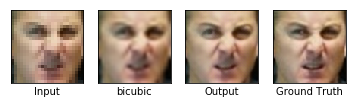

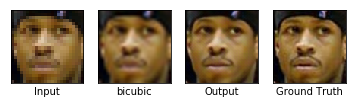

In [7]:
# 提取测试集中的一部分数据作为展示
raw = normalize(x_test[:batch_size])
mos, fake = sess.run(
        [model.downscaled, model.imitation],
        feed_dict={x: raw, is_training: False})
mos_tmp = mos.copy()
save_img([mos, mos_tmp, fake, raw], ['Input','bicubic','Output','Ground Truth'], epoch)

从上面结果可以看到，双三次插值生成的图像相对比较模糊平滑，细节信息丢失严重，而SRGAN的效果要比传统双三次插值的主观视觉效果好，细节信息更加丰富，接近Ground Truth。